In [ ]:
images = []
import os
for folder in os.listdir("/content/mrlEyes_2018_01"):
  for file in os.listdir("/content/mrlEyes_2018_01/"+folder):
    images.append("/content/mrlEyes_2018_01/"+folder + "/"+file)

FileNotFoundError: [Errno 2] No such file or directory: '/content/mrlEyes_2018_01'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
p=os.listdir("/content/drive/MyDrive/EyesDataset")
len(p)
p

['s0029_00861_0_0_1_0_1_01.png',
 's0029_00744_0_0_1_0_1_01.png',
 's0029_00710_0_0_1_0_1_01.png',
 's0029_00978_0_0_1_0_1_01.png',
 's0029_00721_0_0_1_0_1_01.png',
 's0029_00682_0_0_1_0_1_01.png',
 's0029_00393_0_0_1_0_1_01.png',
 's0029_00830_0_0_1_0_1_01.png',
 's0029_00026_0_0_0_0_1_01.png',
 's0029_00821_0_0_1_0_0_01.png',
 's0029_01102_0_0_1_0_1_01.png',
 's0029_00664_0_0_1_0_1_01.png',
 's0029_00424_0_0_1_0_1_01.png',
 's0029_00223_0_0_1_0_1_01.png',
 's0029_01200_0_0_1_0_1_01.png',
 's0029_00560_0_0_1_0_1_01.png',
 's0029_00852_0_0_1_0_1_01.png',
 's0029_01036_0_0_1_0_1_01.png',
 's0029_01040_0_0_1_0_1_01.png',
 's0029_00681_0_0_1_0_1_01.png',
 's0029_00207_0_0_1_0_1_01.png',
 's0029_01051_0_0_1_0_1_01.png',
 's0029_01085_0_0_1_0_1_01.png',
 's0029_00494_0_0_1_0_1_01.png',
 's0029_01084_0_0_1_0_1_01.png',
 's0029_00208_0_0_1_0_1_01.png',
 's0029_00126_0_0_0_0_1_01.png',
 's0029_01243_0_0_1_0_1_01.png',
 's0029_00289_0_0_1_0_1_01.png',
 's0029_00097_0_0_0_0_0_01.png',
 's0029_00

In [ ]:
source_folder = '/content/EyesDataset'
destination_folder = '/content/drive/MyDrive/'
import shutil
# Move the folder
shutil.move(source_folder, destination_folder)

print("Folder has been successfully moved to Google Drive.")

Folder has been successfully moved to Google Drive.


In [4]:
!pip install keras-flops

In [5]:
import keras
print(keras.__version__)

3.3.3


In [1]:

import cv2     # for capturing videos
import os
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
# %matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from keras.layers import Input,Dense, InputLayer, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, multiply
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, multiply
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Lambda
import tensorflow as tf

In [7]:
def net_flops(model, table=False):
    if (table == True):
        print('%25s | %16s | %16s | %16s | %16s | %6s | %6s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS'))
        print('-' * 170)

    t_flops = 0
    t_macc = 0

    for l in model.layers:

        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if ('InputLayer' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if ('Reshape' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if ('Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('Average' in str(l) and 'pool' not in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('BatchNormalization' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('Activation' in str(l) or 'activation' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('pool' in str(l) and ('Global' not in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if ('Flatten' in str(l)):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if ('Dense' in str(l)):
            print(l.input)
            i_shape = l.input.shape[1:4].as_list()[0]
            if (i_shape == None):
                i_shape = out_vec

            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if ('Padding' in str(l)):
            flops = 0

        if (('Global' in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc

        t_flops += flops

        if (table == True):
            print('%25s | %16s | %16s | %16s | %16s | %6s | %5.4f' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), flops))
    t_flops = t_flops / factor

    print('\nTotal FLOPS (x 10^6): %10.8f\n' % (t_flops))
    print('\nTotal MACCs: %10.8f\n' % (t_macc))

    return

In [8]:
"""#Dataset Preparation"""

def label_img(img):
  try:
    word_label = img.split('_')[4]
    if word_label[0] == '1': return 1
    elif word_label[0] == '0': return 0
  except :
    pass
    #[1] eyes are open
    #[0] eyes are closed
import os
def create_dataset(dir):
    dataset_path = []
    dataset_label = []
    for img in tqdm(os.listdir(dir)):
        label = label_img(img)
        if np.array(label) == 1:
            label_str = 'open'
        if np.array(label) == 0:
            label_str = 'close'
        path = os.path.join(dir, img)
        #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        dataset_path.append(path)
        dataset_label.append(label_str)
    df = pd.DataFrame()
    df['Path'] = dataset_path
    df['Label'] = dataset_label
    #np.save('train_data.npy', dataset)
    return df

train_dir = 'C:/Users/aymane/Desktop/DMS/EyesDataset'
test_dir = 'C:/Users/aymane/Desktop/DMS/EyesDataset'
train_df = create_dataset(train_dir)
test_df = create_dataset(test_dir)

train_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory="C:/Users/aymane/Desktop/DMS/EyesDataset",
                x_col="Path",
                y_col="Label",
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="binary",
                target_size=(100,100))
val_gen = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory="C:/Users/aymane/Desktop/DMS/EyesDataset",
                x_col="Path",
                y_col="Label",
                subset="validation",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="binary",
                target_size=(100,100))
test_gen = test_datagen.flow_from_dataframe(
                dataframe=test_df,
                directory="C:/Users/aymane/Desktop/DMS/EyesDataset",
                x_col="Path",
                y_col="Label",
                batch_size=32,
                seed=42,
                shuffle=False,
                class_mode="binary",
                target_size=(100,100))
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)


100%|██████████| 84898/84898 [00:00<00:00, 167176.61it/s]


Found 63674 validated image filenames belonging to 2 classes.
Found 21224 validated image filenames belonging to 2 classes.
Found 84898 validated image filenames belonging to 2 classes.
{'close': 0, 'open': 1}
{'close': 0, 'open': 1}
{'close': 0, 'open': 1}


In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Initialize the VGG model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()

# Add the VGG convolutional base model
model.add(base_model)
model.add(Flatten())
model.add(Dense(84, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

# Configure the model for training
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy']
)

# If you still want to include additional Conv layers, use this part
custom_model = Sequential()
custom_model.add(Input(shape=(100, 100, 3)))

custom_model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

custom_model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

custom_model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

custom_model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

custom_model.add(Conv2D(filters=1024, kernel_size=(3, 3), strides=1, padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
custom_model.add(Flatten())

custom_model.add(Dense(180, activation='relu', kernel_regularizer=l2(0.01)))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
custom_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
custom_model.add(Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
custom_model.summary()

# Configure the model for training
custom_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy']
)

# Print the FLOPS of each model if needed
# net_flops(base_model, table=True)
# net_flops(custom_model, table=True)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 100, 100, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 100, 100, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 25, 25, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 25, 25, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 25, 25, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 512)    │     1,769,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 512)      │             

 Total params: 10,777,705 (41.11 MB)

 Trainable params: 10,772,905 (41.10 MB)

 Non-trainable params: 4,800 (18.75 KB)

In [10]:
# Measure time per layer in keras
import time
def time_per_layer(model):
    new_model = model

    times = np.zeros((len(model.layers), 2))
    inp   = np.ones((100,100,3))


    for i in range(1, len(model.layers)):
        new_model = keras.models.Model(inputs=[model.input], outputs=[model.layers[-i].output])

        # new_model.summary()
        new_model.predict(inp[None, :, :, :])

        t_s = time.time()
        new_model.predict(inp[None, :, :, :])
        t_e2 = time.time() - t_s

        times[i, 1] = t_e2
        del new_model

    for i in range(0, len(model.layers) - 1):
        times[i, 0] = abs(times[i + 1, 1] - times[i, 1])

    times[-1, 0] = times[-1, 1]


    return times

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━

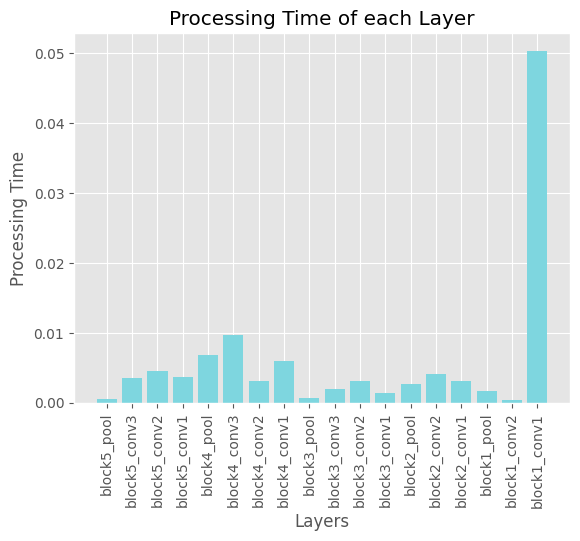

In [11]:
#from keras.applications.vgg19 import VGG19
#model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape= (100,100,3),)

model = base_model
times = time_per_layer(model)

# Visualize

import matplotlib.pyplot as plt

plt.style.use('ggplot')
x = [model.layers[-i].name for i in range(1,len(model.layers))]
#x = [i for i in range(1,len(model.layers))]
g = [times[i,0] for i in range(1,len(times))]
x_pos = np.arange(len(x))
plt.bar(x, g, color='#7ed6df')
plt.xlabel("Layers")
plt.ylabel("Processing Time")
plt.title("Processing Time of each Layer")
plt.xticks(x_pos, x,rotation=90)

plt.show()

In [13]:
"""#Training"""

# Import time module
import time




weight_save_path = "/content/drive/MyDrive/Thesis/my_try/weight/"
weight_name = "my_try_custom5.weights.h5"
model_save_path = "/content/drive/MyDrive/Thesis/my_try/model/"
model_name = "my_try_custom5.keras"

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-9)
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, mode='min', restore_best_weights=True)
checkpoint1 = ModelCheckpoint(weight_save_path + weight_name, monitor='val_accuracy', save_best_only=True, save_weights_only=True)
checkpoint2 = ModelCheckpoint(model_save_path + model_name, monitor='val_accuracy', save_best_only=False, save_weights_only=False)


In [20]:
from PIL import Image 
import time
start = time.time()
history = model.fit(
      train_gen,
      steps_per_epoch=(train_gen.samples)//train_gen.batch_size,
      validation_data=val_gen,
      validation_steps=(val_gen.samples)//val_gen.batch_size,
      epochs=1,
      callbacks=[lr_reduce, checkpoint1,checkpoint2]
      )
stop = time.time()
print(f"Training time: {stop - start}s")



import timeit

start = timeit.default_timer()



stop = timeit.default_timer()

print('Time: ', stop - start)

1989/1989 ━━━━━━━━━━━━━━━━━━━━ 989s 497ms/step - accuracy: 0.9103 - loss: 0.3525 - precision_4: 0.9336 - recall_4: 0.9091 - val_accuracy: 0.8159 - val_loss: 0.5286 - val_precision_4: 0.6211 - val_recall_4: 0.9300 - learning_rate: 1.0000e-04
Training time: 989.0039839744568s
Time:  2.3399999918183312e-05


In [28]:
import tensorflow as tf

# Save the model weights
model.save_weights('model_weights.weights.h5')

# Save the full model in TensorFlow SavedModel format
model.save('full_model.keras')  # This saves the model in the SavedModel format




In [29]:
model_custom_model = keras.models.load_model("C:/Users/aymane/Desktop/DMS/full_model.keras")
model_custom_model.load_weights("C:/Users/aymane/Desktop/DMS/model_weights.weights.h5")
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()

pred_custom_model=model_custom_model.predict(test_gen,
steps=STEP_SIZE_TEST+1,
verbose=1)

c:\Users\aymane\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2654/2654 ━━━━━━━━━━━━━━━━━━━━ 983s 370ms/step


In [30]:
print(pred_custom_model)

[[0.2981753 ]
 [0.3513408 ]
 [0.38017473]
 ...
 [0.9885219 ]
 [0.5869272 ]
 [0.98777395]]


In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model('C:/Users/aymane/Desktop/DMS/full_model.keras') # path to the SavedModel directory
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model) 

OSError: SavedModel file does not exist at: C:/Users/aymane/Desktop/DMS/full_model.keras\{saved_model.pbtxt|saved_model.pb}

In [4]:
import keras
import tensorflow as tf
model = keras.models.load_model("C:/Users/aymane/Desktop/DMS/full_model.keras")


# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved successfully.")

INFO:tensorflow:Assets written to: C:\Users\aymane\AppData\Local\Temp\tmp6ued_stl\assets


INFO:tensorflow:Assets written to: C:\Users\aymane\AppData\Local\Temp\tmp6ued_stl\assets


: 

# Train the model
start = time.time()
history = model.fit(
      train_gen,
      steps_per_epoch=(train_gen.samples)/train_gen.batch_size,
      validation_data=val_gen,
      validation_steps=(val_gen.samples)/val_gen.batch_size,
      epochs=1,
      callbacks=[lr_reduce, checkpoint1,checkpoint2]
      )
stop = time.time()
print(f"Training time: {stop - start}s")



import timeit

start = timeit.default_timer()



stop = timeit.default_timer()

print('Time: ', stop - start)